This notebook shows how to apply PCA and XGB Boosted Forest Classifers to a multiclass classification problem. 
In addition, we compute various performance metrics on the fitted model, applied to both training and testing dataset. 

In [1]:
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn import metrics
from sklearn.datasets import load_iris
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt

In [2]:
class classifier_statistics:
    
    # cm_{ij}: group i is true label, group j is predicted label (opposite of wiki) 
    
    def __init__(self):
        self.data=[]
    
    def compute_stats(self,cm,title):
        df = pd.DataFrame([
        ['Avg Precision', self.precision(cm,'avg')],
        ['Avg Recall',    self.recall(cm,'avg')],
        ['Accuracy',      self.accuracy(cm)],
        ['Avg F1',        self.F1(cm)]],
            columns=['Statistic',title])
        return df
    
    def precision(self,cm,method='array'):
        n = len(cm)
        out = np.zeros(n)
        for i in range(n):
            b = np.sum(cm[:,i])
            if(b==0.):
                out[i] = 1.
            else:
                out[i] = cm[i][i]/b

        if(method=='avg'):
            out = np.mean(out)
        return out


    def recall(self,cm,method='array'):
        n = len(cm)
        out = np.zeros(n)
        for i in range(n):
            b = np.sum(cm[i,:])
            if(b==0.):
                out[i] = 1.
            else:
                out[i] = cm[i][i]/b
        if(method=='avg'):
            out = np.mean(out)
        return out

    def accuracy(self,cm):
        n = len(cm)
        num = np.sum([cm[i][i] for i in range(n)])
        denom = np.sum(cm)
        return (num/denom)


    def F1(self,cm):
        prec = self.precision(cm,'avg')
        rec = self.recall(cm,'avg')
        out = 2*prec*rec/(prec+rec)
        return out


def prepare_data(xtrain,xtest,ncomponents):
    mu = np.mean(xtrain,axis=0)
    sigma = np.std(xtrain,axis=0,ddof=0)

    xtrain = (xtrain-mu)/sigma # using biased variance
    xtest = (xtest-mu)/sigma # using biased variance, use train data

    pca = PCA(n_components=ncomponents) # PCA
    xtrain = pca.fit_transform(xtrain)
    xtest = pca.transform(xtest) # train data

    return xtrain,xtest,pca


def visualize(df_pc,names,title_name):
    fig,ax = plt.subplots(1,1)
    for i in range(len(target_names)):
        df = df_pc[df_pc['targets']==i]
        ax.scatter(df['PC1'],df['PC2'],label=target_names[i])
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_title(title_name+' set PCA Decomposition Iris Dataset')
    ax.legend()
    return fig,ax

def multicollinearity_statistics(x_dat,cols):
    df_fullData = pd.DataFrame(x_dat,columns=cols)
    display(df_fullData.corr())

    df_fullData['const'] = 1.0
    s = pd.Series([variance_inflation_factor(df_fullData.values, i) for i in range(df_fullData.shape[1])], index=df_fullData.columns,name='VIF Index')
    display(s)
    return None

class XGB_Wrapper:
    def __init__(self,xtrain,ytrain,xtest,ytest):
        self.data={}
        self.cm = {}        
        self.data['train'] = [xtrain,ytrain]
        self.data['test'] = [xtest,ytest]

    def fit(self,param):
        self.xgbc = xgb.XGBClassifier(**param)
        self.xgbc.fit(self.data['train'][0], self.data['train'][1])
        return None
    
    def feature_importances(self):
        return self.xgbc.feature_importances_
    
    def set_cm(self,which):
        self.y_proba = self.xgbc.predict_proba(self.data[which][0])
        self.y_pred = self.xgbc.predict(self.data[which][0])
        self.cm[which] = confusion_matrix(self.data[which][1],self.y_pred)
        return None
    
    def set_statistics(self):
        self.set_cm('train')
        self.set_cm('test')

        mc_stats = classifier_statistics()
        df_train = mc_stats.compute_stats(self.cm['train'],'train')
        df_test = mc_stats.compute_stats(self.cm['test'],'test')
        df = df_train.merge(df_test,how='inner')        
        return df

    def roc(self):
        tpr = {}
        fpr = {} 
        thresh = {}
        auc = {}
        n_class = len(self.cm['test'])

        for i in range(n_class):
            fpr[i], tpr[i], thresh[i] =  metrics.roc_curve(self.data['test'][1], self.y_proba[:,i], pos_label=i)
            auc[i] = round(metrics.auc(fpr[i], tpr[i]),2)
        return fpr,auc,tpr

def xgb_kfold(model,nsplit,param):
    
    if(nsplit==-1):
        df = model.set_statistics()
        return df
    
    xtrain = model.data['train'][0]
    ytrain = model.data['train'][1]
        
    kfold = KFold(n_splits=nsplit, shuffle=False)
    df_stats = pd.DataFrame(columns=['Statistic','train','test'])

    for train_index, test_index in kfold.split(xtrain):
        X_train, X_test = xtrain[train_index], xtrain[test_index]
        Y_train, Y_test = ytrain[train_index], ytrain[test_index]
        
        xgb_wrap = XGB_Wrapper(X_train,Y_train,X_test,Y_test)
        xgb_wrap.fit(param)
        df = xgb_wrap.set_statistics()
        
        df_stats = df_stats.append(df)
    
    df_stats = df_stats.groupby('Statistic').agg({'train':'mean','test':'mean'})
    return df_stats


In [3]:
# Load data, inspect dataset
iris = load_iris()

target_names = {}
for i in range(len(iris.target_names)):
    target_names[i] = iris.target_names[i]

x, y = iris.data, iris.target
xtrain_raw, xtest_raw, ytrain, ytest=train_test_split(x, y, test_size=0.3,random_state=5)

multicollinearity_statistics(xtrain_raw,iris.feature_names)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
sepal length (cm),1.000000,-0.069550,0.870781,0.819877
sepal width (cm),-0.069550,1.000000,-0.398694,-0.349993
petal length (cm),0.870781,-0.398694,1.000000,0.965208
petal width (cm),0.819877,-0.349993,0.965208,1.000000


sepal length (cm)      7.424038
sepal width (cm)       2.123868
petal length (cm)     31.703121
petal width (cm)      16.648953
const                119.487628
Name: VIF Index, dtype: float64

From the correlation matrix, we see that petal length and petal width are highly correlated with each other. 
From the VIF Index, we see that both petal length/width are above 10, which as a rule of thumb suggests multicollinearity. Let's do PCA.

In [4]:
# Better!
pca_columns = ['PC1','PC2']
xtrain,xtest,pca = prepare_data(xtrain_raw,xtest_raw,len(pca_columns))
multicollinearity_statistics(xtrain,pca_columns)

,PC1,PC2
PC1,1.000000e+00,-2.501031e-16
PC2,-2.501031e-16,1.000000e+00


PC1      1.0
PC2      1.0
const    1.0
Name: VIF Index, dtype: float64

Explained variance: 0.96


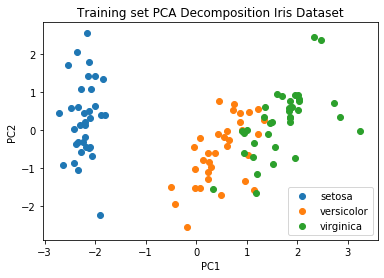

In [5]:
# Visualize
df_train = pd.DataFrame(xtrain,columns=pca_columns)
df_train['targets'] = ytrain
df_test = pd.DataFrame(xtest,columns=pca_columns)
df_test['targets'] = ytest
print('Explained variance:',round(sum(pca.explained_variance_ratio_),len(pca_columns)))
visualize(df_train,target_names,'Training')
None

In [8]:
# Search for best model
learning_rates=np.linspace(0.1,1,1)
max_depths = [2,3]
ns_estimators = [2,4]

# 
grid_search = []
best_score=-1
for lr in learning_rates:
    for md in max_depths:
        for ne in ns_estimators:
            
            param = {'learning_rate':lr,'subsample':1,'nthread':3,'max_depth':md,'n_estimators':ne,'objective':'multi:softmax','booster':'gbtree','num_class':3}
            xgb_wrap = XGB_Wrapper(xtrain,ytrain,xtest,ytest)
            xgb_wrap.fit(param)
            out = xgb_kfold(xgb_wrap,5,param)
            if(best_score<out.loc['Avg F1','test']):
                best_param = param
                best_score = out.loc['Avg F1','test']
                
            grid_search.append([lr,md,ne,out.loc['Avg F1','train'],out.loc['Avg F1','test']])
sorted(grid_search, key=lambda x: x[-1],reverse=True)

[[0.1, 2, 2, 0.928515407145569, 0.8751336310238764],
 [0.1, 2, 4, 0.928515407145569, 0.8751336310238764],
 [0.1, 3, 2, 0.9457389485864691, 0.8650375523799934],
 [0.1, 3, 4, 0.9504739384814791, 0.8424174898622325]]

In [9]:
# kFold Validation
print('Subtrain and subtest results')
display(xgb_kfold(xgb_wrap,5,best_param))


# Test set results
print('Train and test results')
display(xgb_kfold(xgb_wrap,-1,best_param))

xgb_wrap.feature_importances()

Subtrain and subtest results


,train,test
Statistic,,
Accuracy,0.923810,0.876190
Avg F1,0.928515,0.875134
Avg Precision,0.931142,0.901111
Avg Recall,0.925911,0.852989


Train and test results


,Statistic,train,test
0,Avg Precision,0.935760,0.941176
1,Avg Recall,0.932462,0.937500
2,Accuracy,0.933333,0.933333
3,Avg F1,0.934108,0.939335


array([0.97095174, 0.02904825], dtype=float32)

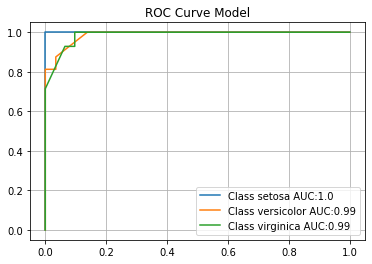

In [10]:
# Plot Multiclass One versus All ROC curve on test set, calculate AUC
xgb_wrap.set_statistics()
fpr,auc,tpr = xgb_wrap.roc()

fig,ax = plt.subplots(1,1)
for i in range(3):
    ax.plot(fpr[i],tpr[i],label='Class '+str(target_names[i])+' AUC:'+str(auc[i]))
ax.legend()
ax.set_title('ROC Curve Model')
ax.grid()
None